# SCOP sample clustering

# import

In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
import scipy as sp
from scipy.cluster.hierarchy import linkage # fcluster, to_tree, dendrogram, 
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import warnings
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

from pathlib import Path

In [2]:
import matplotlib.colors as mcolors

def lighter_shades(hex_color, n_shades=4):
    rgb = mcolors.hex2color(hex_color)
    shades = [mcolors.to_hex(rgb)]
    for i in range(1, n_shades+1):
        factor = 1 - (i * 0.15)
        lighter = tuple(1 - (1 - c) * factor for c in rgb)
        shades.append(mcolors.to_hex(lighter))
    return shades



In [3]:
from module.Ceval.dendrogram_eval import get_clustering_stats
from module.PGMD import SSE_read, pair_PGMD
from module.sse_matching_master_draft import invd_sim_func, forward_chain_adj_prep
from module.cluster_utils import dendrogram_clustering


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## init params:

In [ ]:
save_things=False


In [6]:

cwd = Path.cwd()
fig_dir = cwd.parent / 'figures' 

# data

In [7]:
# from full scop database:
fpath = '../../data/proteins/scop-cla-latest.txt'

with open(fpath) as f:
    lines = f.readlines()




In [8]:
headers = lines[5].strip('#').strip('\n').split(' ')[1:]

scop_df = pd.DataFrame([l.strip('\n').split(' ') for l in lines[6:]], columns=headers)



In [9]:

scopcla_col = [eval('dict(' + i + ')') for i in scop_df.SCOPCLA.values]
scopcla_df = pd.DataFrame(scopcla_col)

In [10]:
name_key = dict(TP='type', CL='class', CF='fold', SF='superfamily', FA='family')

TP=protein type, CL=protein class, CF=fold, SF=superfamily, FA=family

- **type**: four groups; soluble, membrane, fibrous and intrinsically disordered.
- **class**: 5 structural classes; all-alpha and all-beta proteins, containing predominantly alpha-helices and beta-strands, respectively, and ‘mixed’ alpha and beta classes (a/b) and (a+b) with respectively alternating and segregated alphahelices and beta-strands, and the fifth class of small proteins with little or no secondary structures. 
- **family**: closely related proteins with a clear evidence for their evolutionary origin.
- **superfamily**: groups together more distantly related protein domains.
- **fold**: global structural features shared by the majority of consitutent superfamily members. Some families with same superfamily can belong to different folds. 




In [11]:
scop_df['FA-PDBREG_a'] = scop_df['FA-PDBREG'].str.split(':').apply(lambda x:x[0])

In [12]:
scop_df['p_id'] = scop_df['FA-PDBID'].str.lower() +'_' + scop_df['FA-PDBREG_a'] 

In [13]:
scopcla_df['p_id'] = scop_df['p_id']

In [14]:
class_sample = scopcla_df.groupby('CL').sample(random_state=0)
sample_pid = class_sample.p_id.values

In [15]:
# known pairs
fpath = '../../data/proteins/pairs.txt'
known_pairs = pd.read_csv(fpath,delimiter = "\t").to_numpy()

In [16]:
# # domains

# fpath = './data/domains/SCOP_domain.txt'
# with open(fpath) as f:
#     lines = f.readlines()
# splt = [i.split() for i in lines]
# dashcount = [i.count("-") for i in lines]

# domain_data = []

# for row, ndash in zip(splt, dashcount):
#     dms = int(ndash/3)
#     for dno in range(dms):
#         domain_data.append({'d_id':row[0], 'p_id':row[1], 'pdb_mb':row[2 + (dno)],\
#                              'r_idx':row[2+dms + dno], 'sse_idx':row[2+(2*dms) + dno],\
#                              'domain':row[(3+(3*dms)):], 'dno':dno})
# domain_data=pd.DataFrame(domain_data)

# domain_dict = domain_data.groupby('d_id').p_id.apply(set).to_dict()

# nonsingle_domain_dict = {key:val for key, val in domain_dict.items() if len(val)>1}

# nonsingle_domains = list(nonsingle_domain_dict.keys())


In [17]:
fpath = '../../data/proteins/scop_sse_range.txt'
scop_ranges = pd.read_csv(fpath, delimiter='\t', header=None)
scop_ranges.columns = ['d_id', 'p_id', 'idx_range']

In [18]:
scop_ranges.d_id = scop_ranges.d_id.astype(str)

In [19]:
fpath = '../../data/proteins/filter_scop.txt'
scop_rf = pd.read_csv(fpath, delimiter='\t', header=None)
scop_rf.columns = ['p_id', 'seq']

In [20]:
scop_rf['res_len'] = scop_rf['seq'].apply(len)

In [21]:
res_len_dict = scop_rf.set_index('p_id').res_len.to_dict()

In [22]:
# rfiltered_pids = np.stack(scop_rf.p_id.str.upper().str.split('_').apply(np.array).values)

rfiltered_pids = scop_rf.p_id.values

In [23]:
scop_rf_df = scop_df[scop_df['p_id'].isin(rfiltered_pids)]

In [24]:
scop_rf_df

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,SF-DOMID,SF-PDBID,SF-PDBREG,SF-UNIID,SF-UNIREG,SCOPCLA,FA-PDBREG_a,p_id
0,8000061,2DT5,A:2-77,Q5SHS3,2-77,8001519,2DT5,A:4-63,Q5SHS3,4-63,"TP=1,CL=1000003,CF=2000144,SF=3000034,FA=4000057",A,2dt5_A
1,8000376,2FR0,A:1448-1915,Q03131,1395-1862,8000377,2FR0,A:1657-1915,Q03131,1604-1862,"TP=1,CL=1000002,CF=2000148,SF=3000038,FA=4000119",A,2fr0_A
2,8000693,1UDC,A:1-338,P09147,1-338,8000694,1UDC,A:1-263,P09147,1-263,"TP=1,CL=1000002,CF=2000148,SF=3000038,FA=4000088",A,1udc_A
3,8000768,2PWZ,A:1-312,P61889,1-312,8000769,2PWZ,A:1-312,P61889,1-312,"TP=1,CL=1000002,CF=2000005,SF=3000039,FA=4000045",A,2pwz_A
4,8000794,1MG5,A:1-255,P00334,2-256,8001233,1MG5,A:1-240,P00334,2-241,"TP=1,CL=1000002,CF=2000148,SF=3000038,FA=4000029",A,1mg5_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36895,8018581,3THX,B:217-1120,P20585,226-1129,8056712,3THX,B:357-507,P20585,366-516,"TP=1,CL=1000002,CF=2001251,SF=3000587,FA=4004015",B,3thx_B
36896,8018581,3THX,B:217-1120,P20585,226-1129,8056714,3THX,B:845-1053,P20585,854-1062,"TP=1,CL=1000002,CF=2001251,SF=3002020,FA=4004015",B,3thx_B
36897,8018583,2O8B,B:362-1335,P52701,362-1335,8056718,2O8B,B:423-487,P52701,423-487,"TP=1,CL=1000002,CF=2001251,SF=3001688,FA=4004015",B,2o8b_B
36898,8018583,2O8B,B:362-1335,P52701,362-1335,8056719,2O8B,B:537-697,P52701,537-697,"TP=1,CL=1000002,CF=2001251,SF=3000587,FA=4004015",B,2o8b_B


In [25]:
rf_p_ids = list(set(scop_ranges.p_id) & set(scop_rf.p_id)) # proteins in both redundancy filtered and scop index range files (from Runfeng)...!

In [26]:
scopcla_df_rf = scopcla_df.query('p_id.isin(@rf_p_ids)')

In [27]:
scopcla_df_rf.value_counts('FA')

FA
4000029    390
4003661    350
4000236    205
4000229    192
4000333    190
          ... 
4001267      1
4001264      1
4001259      1
4001257      1
4007845      1
Name: count, Length: 5353, dtype: int64

In [28]:
sampled_sf = scopcla_df_rf.groupby(['SF', 'FA']).p_id.apply(len).sample(3, random_state=3).index.values

In [29]:
scopcla_df_rf.groupby(['SF', 'FA']).p_id.apply(len).sample(3, random_state=3)

SF       FA     
3000970  4005365     4
3001528  4002636    85
3000896  4003453     7
Name: p_id, dtype: int64

In [30]:
scopcla_df_rf.groupby(['SF', 'FA']).p_id.apply(len).reset_index()

,SF,FA,p_id
0,3000001,4000007,5
1,3000001,4000137,1
2,3000001,4000145,1
3,3000001,4000148,2
4,3000001,4000189,2
...,...,...,...
5516,3002868,4005628,1
5517,3002869,4006150,3
5518,3002870,4005881,2
5519,3002872,4007845,1


In [31]:
scopcla_df_rf.loc[:,'res_len']= scopcla_df_rf.p_id.apply(lambda x: res_len_dict.get(x))

/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_8517/4072409549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scopcla_df_rf.loc[:,'res_len']= scopcla_df_rf.p_id.apply(lambda x: res_len_dict.get(x))


In [32]:
scopcla_df_rf.sort_values('res_len').head(50).p_id.values

array(['1rk8_C', '1dxg_A', '7m4v_3', '1xu1_R', '6wu9_6', '5ky2_B',
       '1p9g_A', '1xdt_R', '1px9_A', '1q9b_A', '5k3q_B', '1mvf_D',
       '1ozz_A', '5jpx_A', '6rxn_A', '5v7q_6', '2jwg_A', '1ti5_A',
       '1e8q_A', '1qhk_A', '1wja_A', '3q1d_A', '3bsu_A', '1e0g_A',
       '1nql_B', '1mox_C', '1nd9_A', '5bum_A', '4uwq_I', '2jn0_A',
       '4llg_M', '3g36_C', '2eqp_A', '2odk_A', '1tpn_A', '1iox_A',
       '3ltg_D', '4nw3_A', '7r6p_A', '2pnx_A', '2qic_A', '3fdt_A',
       '2hbb_A', '2p3u_A', '1rb9_A', '3bdu_A', '1rdv_A', '1k8b_A',
       '2dsx_A', '1qmc_A'], dtype=object)

In [33]:
FA_to_pid = scopcla_df_rf.groupby('FA').p_id.apply(len)

In [34]:
fa_gt_5 = FA_to_pid[FA_to_pid>5].index.values

In [35]:
print('Number of domain families with greater than 5 proteins:', len(fa_gt_5))



Number of domain families with greater than 5 proteins: 1156


In [36]:
SF_to_FA = scopcla_df_rf.query('FA.isin(@fa_gt_5)').groupby('SF').FA.apply(set)

In [37]:
sf_gt_5 = SF_to_FA[SF_to_FA.apply(len)>5].index.values

In [38]:
# SF_to_FA[SF_to_FA.apply(len)>5]

In [39]:
# From a set of FA, SF greater than 5, sample 6 SFs.
sf_sampled_df = scopcla_df_rf.query('FA.isin(@fa_gt_5)').query('SF.isin(@sf_gt_5)').groupby(['CL', 'SF', 'FA']).p_id.apply(set).reset_index().groupby('SF').sample(5, random_state=0)

In [40]:
sf_sampled_df['lens'] = sf_sampled_df['p_id'].apply(len)

In [41]:
# sample just SFs:
sampled_sf = sf_sampled_df.groupby('SF').lens.apply(sum).sample(4, random_state=2).index.values

# Sample SFs for one from class:
# sampled_sf = sf_sampled_df.drop_duplicates(subset=['CL', 'SF']).groupby('CL').sample(1, random_state=1).SF.values

/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_8517/1009272018.py:2: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  sampled_sf = sf_sampled_df.groupby('SF').lens.apply(sum).sample(4, random_state=2).index.values


In [42]:
# sampled_sf = sf_sampled_df.drop_duplicates(subset=['CL', 'SF']).groupby('CL').sample(1, random_state=1).SF.values

In [43]:
sf_sampled_df.drop_duplicates(subset=['CL', 'SF']).groupby('CL').sample(1, random_state=1)

,CL,SF,FA,p_id,lens
2,1000000,3000001,4000325,"{1pdn_C, 6pax_A, 1k78_A}",3
36,1000001,3000120,4002124,"{5vx4_A, 6ha0_A, 7c8p_B, 5gj6_A, 5caz_A, 2dwr_...",14
108,1000002,3000216,4003056,"{1ka9_F, 4wd0_A, 5ac7_A, 2vep_A, 1thf_D, 4x9s_...",14
151,1000003,3000034,4000157,"{1i5z_A, 3e5u_C, 2h6c_A, 2zcw_A, 1zyb_A, 2gau_...",9
213,1000004,3000068,4003634,"{2cu8_A, 2cur_A, 1x62_A, 2o13_A, 1x64_A, 1b8t_...",19


In [44]:
# sf_sampled_df

sf_sampled_df.groupby(['CL', 'SF']).apply(lambda x: x.sample(n=1, random_state=0)).reset_index(drop=True)

/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_8517/3459732955.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sf_sampled_df.groupby(['CL', 'SF']).apply(lambda x: x.sample(n=1, random_state=0)).reset_index(drop=True)


,CL,SF,FA,p_id,lens
0,1000000,3000001,4000332,"{5chh_A, 1bl0_A, 1d5y_A}",3
1,1000000,3000157,4000747,"{1ef1_A, 2kma_A, 5ejr_A, 3pvl_A, 5ejy_A, 1gg3_...",13
2,1000000,3001983,4000919,"{4dir_A, 1ozo_A, 5k89_A, 1cb1_A, 1qls_A, 1e8a_...",25
3,1000001,3000070,4007519,"{1qfh_A, 2w0p_A, 1v05_A, 2ds4_A, 2e9i_A}",5
4,1000001,3000071,4007529,"{2nxy_B, 1dr9_A, 1cid_A, 1iam_A, 2d9q_B, 1vca_...",9
5,1000001,3000087,4002480,"{1i5p_A, 1dlc_A, 1ji6_A, 6owk_A, 6dj4_A, 1ciy_A}",6
6,1000001,3000120,4002734,"{2y9n_A, 6su8_A, 3ovw_A, 4csi_A, 4v1z_A, 2rfw_...",21
7,1000001,3000135,4000346,"{3fhw_A, 3ull_A, 5odn_B, 6bhw_F, 5yyu_A, 3eiv_...",41
8,1000002,3000031,4002953,"{2ojl_A, 2a4h_A, 2a2p_A, 2oka_A, 2obk_F, 2p0g_...",8
9,1000002,3000068,4003437,"{2j9r_A, 1xbt_G, 2ja1_A, 1xx6_A, 2j87_A, 2b8t_...",8


In [45]:
sampled_sf

array([3002021, 3000001, 3000102, 3001808])

In [46]:
sampled_sf

array([3002021, 3000001, 3000102, 3001808])

In [47]:
sf_sampled_df.groupby(['CL', 'SF']).FA.apply(list)

CL       SF     
1000000  3000001             [4000325, 4000317, 4000332, 4000291]
         3000157                                        [4000747]
         3001983    [4000949, 4003019, 4000919, 4000924, 4000946]
1000001  3000070    [4004454, 4007565, 4007519, 4004427, 4007569]
         3000071    [4007543, 4007530, 4007529, 4007744, 4000202]
         3000087    [4002471, 4005087, 4002480, 4002476, 4002473]
         3000120    [4002124, 4004563, 4002734, 4002742, 4002689]
         3000135    [4001931, 4001909, 4000346, 4001884, 4001935]
1000002  3000031    [4000237, 4000084, 4002953, 4002945, 4003282]
         3000068                                        [4003437]
         3000092    [4000524, 4000330, 4002236, 4000313, 4003392]
         3000102    [4000699, 4000703, 4003694, 4000242, 4000732]
         3000118    [4000661, 4003609, 4003408, 4003608, 4001157]
         3000143    [4004716, 4005305, 4002242, 4000547, 4000539]
         3000216    [4003056, 4002281, 4003059, 4003071, 40

In [48]:
sampled_FA = sf_sampled_df.query('SF.isin(@sampled_sf)')

In [49]:
sampled_FA

,CL,SF,FA,p_id,lens
147,1000003,3000001,4002873,"{1lfp_A, 1kon_A, 1mw7_A}",3
2,1000000,3000001,4000325,"{1pdn_C, 6pax_A, 1k78_A}",3
1,1000000,3000001,4000317,"{2iw5_B, 1h8a_C, 1a5j_A, 1ofc_X, 2ckx_A, 1ign_...",8
3,1000000,3000001,4000332,"{5chh_A, 1bl0_A, 1d5y_A}",3
0,1000000,3000001,4000291,"{4egc_A, 1ic8_A, 1s7e_A, 1e3o_C, 5flv_M, 1au7_A}",6
71,1000002,3000102,4000699,"{2fj0_A, 1thg_A, 4be4_A, 1ea5_A, 2bce_A, 1c7j_...",23
72,1000002,3000102,4000703,"{1jjf_A, 1wb4_A, 6syl_B, 3qh4_A, 2b20_A, 6z69_...",20
84,1000002,3000102,4003694,"{5ajh_A, 1qoz_A, 4psc_A, 2czq_A, 3dd5_C, 1g66_...",12
70,1000002,3000102,4000242,"{5jkf_B, 6pux_A, 6ioi_B, 5w8o_A, 2b61_A, 3i1i_...",9
78,1000002,3000102,4000732,"{1uwc_A, 3tgl_A, 3o0d_G, 3g7n_A, 6a0w_A, 1tca_...",12


In [50]:
sampled_trials = scopcla_df_rf[scopcla_df_rf['FA'].isin(class_sample.FA.values)].groupby(['CL', 'FA']).sample(2, random_state=2).groupby(['CL', 'FA']).p_id.apply(list).values

In [51]:
filtered_scop_ranges = scop_ranges.query('p_id.isin(@rf_p_ids)')

In [52]:
domain_dict = scopcla_df_rf.groupby('FA').p_id.apply(list).to_dict()

In [53]:
domainlist = list(domain_dict.keys())

In [54]:
sampled_FA.lens.sum()

266

In [55]:
(sampled_FA.lens.sum() *(sampled_FA.lens.sum() -1) /2) *0.1/60

58.74166666666667

In [56]:
sampled_FA

,CL,SF,FA,p_id,lens
147,1000003,3000001,4002873,"{1lfp_A, 1kon_A, 1mw7_A}",3
2,1000000,3000001,4000325,"{1pdn_C, 6pax_A, 1k78_A}",3
1,1000000,3000001,4000317,"{2iw5_B, 1h8a_C, 1a5j_A, 1ofc_X, 2ckx_A, 1ign_...",8
3,1000000,3000001,4000332,"{5chh_A, 1bl0_A, 1d5y_A}",3
0,1000000,3000001,4000291,"{4egc_A, 1ic8_A, 1s7e_A, 1e3o_C, 5flv_M, 1au7_A}",6
71,1000002,3000102,4000699,"{2fj0_A, 1thg_A, 4be4_A, 1ea5_A, 2bce_A, 1c7j_...",23
72,1000002,3000102,4000703,"{1jjf_A, 1wb4_A, 6syl_B, 3qh4_A, 2b20_A, 6z69_...",20
84,1000002,3000102,4003694,"{5ajh_A, 1qoz_A, 4psc_A, 2czq_A, 3dd5_C, 1g66_...",12
70,1000002,3000102,4000242,"{5jkf_B, 6pux_A, 6ioi_B, 5w8o_A, 2b61_A, 3i1i_...",9
78,1000002,3000102,4000732,"{1uwc_A, 3tgl_A, 3o0d_G, 3g7n_A, 6a0w_A, 1tca_...",12


# clustering

In [57]:

chainval, alpha, gamma = 0.733152,	2.735147,	1.681227 

type_to_tex_dict = {'E':r'$\blacksquare$', 'H':r'$\bigcirc$'}
sdict = {'E':'s', 'H':'o'}


In [58]:
pairpathpf = f'../../data/proteins/100_sec_map/sscm'
pairopathpf = '../../data/proteins/100_sec_map/orientation'

sse_inst = SSE_read(fpathprefix=pairpathpf, 
                    opathprefix=pairopathpf, 
                    fpathext='txt', 
                    opathext='txt', 
                    chainval=chainval, 
                    sim_func=invd_sim_func, 
                    chain_func=forward_chain_adj_prep, 
                    threshold=7.5)

pgmd_inst = pair_PGMD(assembly_func=sse_inst.assemble_strict) 


In [59]:
# domains = [4004908, 4004716, 4005006, 4001236, ]
# domains = domainlist[60:80]
# d_pids = [domain_dict[i] for i in domains]

# ids = np.hstack(d_pids)
# print(len(ids))

In [60]:
ids = sorted(list(set().union(*sampled_FA.p_id.values)))

In [61]:
len(ids)

266

In [62]:
trials = [] 

for i in range(len(ids)):
    for j in range(i+1, len(ids)):
        trials.append([ids[i], ids[j]])

In [63]:
len(trials)

35245

In [64]:

# dstats = []
# warned_ids = []
# for id_1, id_2 in trials[:]:
#     sse_inst.reset_SSE()
#     pgmd_inst.refresh()
#     container = pgmd_inst.get_container(pids=[id_1, id_2],)
#     try:
#         with warnings.catch_warnings(record=True) as wlist:
#             warnings.simplefilter("always")
#             run_gm_output = pgmd_inst.run_gm(pids=[id_1, id_2], alpha=alpha, gamma=gamma, use_lengths=True, match_args=None)
#             if wlist:
#                 for w in wlist:
#                     print(f"Warning with id_1={id_1}, id_2={id_2}: {w.message}")
#                     warned_ids.append((id_1, id_2))
#     except Exception as e:
#         print(f"Error with id_1={id_1}, id_2={id_2}: {e}")
#         # with open(f'./data/{nb_name}/error_pairs.txt', 'a') as f:
#         #     f.write(f"{id_1},{id_2}\n")
#         continue
#     # perm_inds = run_gm_output['perm_inds']
#     # g2_to_g1_node_mapping = run_gm_output['node_mapping']
#     # id_1, id_2 = pgmd_inst.sorted_ids # sort the ids
#     layoutput = pgmd_inst.get_layoutput(seed=0)
#     perm_inds = run_gm_output['perm_inds']
#     sorted_ids = pgmd_inst.sorted_ids # sort the ids

#     dstats.append({'id_1':id_1, 'id_2':id_2,'fnorm': layoutput['fnorm'], \
#                  'graph_edit_distance':layoutput['graph_edit_distance'], \
#                  'euclidean_distance': layoutput['euclidean_distance'], \
#                     'perm_inds': perm_inds, 'id_order':sorted_ids})
# dstats_df = pd.DataFrame(dstats)

# dstats_df.to_csv(f'../../data/proteins/processed/sample_sffa_gmd.csv')

In [65]:
dstats_df = pd.read_csv(f'../../data/proteins/processed/sample_sffa_gmd.csv', index_col=0)


In [66]:
dstats_df

,id_1,id_2,fnorm,graph_edit_distance,euclidean_distance,perm_inds,id_order
0,1a5j_A,1aec_A,3.464102,38,7.483315,[ 2 3 14 4 5 7],"['1a5j_A', '1aec_A']"
1,1a5j_A,1agy_A,1.414214,37,7.211103,[ 8 9 13 14 15 16],"['1a5j_A', '1agy_A']"
2,1a5j_A,1aqy_A,2.000000,47,7.483315,[15 16 19 20 21 22],"['1a5j_A', '1aqy_A']"
3,1a5j_A,1au7_A,2.828427,7,3.464102,[0 1 2 4 5 6],"['1a5j_A', '1au7_A']"
4,1a5j_A,1bl0_A,3.741657,13,4.898979,[0 1 4 5 6 2],"['1a5j_A', '1bl0_A']"
...,...,...,...,...,...,...,...
35240,7cc4_A,7cy9_A,7.615773,38,8.366600,[16 17 1 2 8 9 10 11 4 5 12 13 14 6 7],"['7cc4_A', '7cy9_A']"
35241,7cc4_A,7u5f_C,7.211103,35,7.874008,[10 11 12 16 8 9 6 7 0 1 2 3 17 13 14],"['7cc4_A', '7u5f_C']"
35242,7ceg_B,7cy9_A,8.124038,88,11.747340,[10 11 13 14 28 29 30 31 17 18 19 8 9 33 34 ...,"['7cy9_A', '7ceg_B']"
35243,7ceg_B,7u5f_C,8.602325,79,11.045361,[ 8 9 10 11 1 2 6 7 15 16 17 27 28 29 31 ...,"['7u5f_C', '7ceg_B']"


In [67]:
fas = sampled_FA.FA.values

In [68]:
len(ids)

266

In [69]:
sliced_df = scopcla_df_rf.query('(p_id.isin(@ids))&(FA.isin(@fas))&(SF.isin(@sampled_sf))')

In [70]:
sliced_df[sliced_df.duplicated(subset=['p_id'])]

,TP,CL,CF,SF,FA,p_id,res_len
120,1,1000000,2000000,3000001,4000317,1h8a_C,105
123,1,1000000,2000000,3000001,4000317,1a5j_A,110
126,1,1000000,2000000,3000001,4000317,1h88_C,152
127,1,1000000,2000000,3000001,4000317,1h88_C,152
28896,1,1000003,2001257,3002021,4004395,3czp_B,452
35673,1,1000000,2000000,3000001,4000325,6pax_A,133
35677,1,1000000,2000000,3000001,4000332,1bl0_A,116
35787,1,1000000,2000000,3000001,4000325,1k78_A,124
35788,1,1000000,2000000,3000001,4000325,1pdn_C,123
35974,1,1000000,2000000,3000001,4000332,5chh_A,312


In [71]:
sliced_df['fam'] = sliced_df.SF.astype('str') + '_' + sliced_df.FA.astype('str')

/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_8517/2435557883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['fam'] = sliced_df.SF.astype('str') + '_' + sliced_df.FA.astype('str')


In [72]:
# [[{id:i} for id in domain_dict.get(i, [])] for i in fas]
id_to_dom = {}

for dom in fas:
    dids = domain_dict.get(dom, [])

    for id in dids: 
        id_to_dom[id] = dom

In [73]:
fam_dict = sliced_df.set_index('p_id').fam.to_dict()


In [74]:
# dist_type = 'euclidean_distance'

# # which_df = sample.groupby('id_2')['id_1'].apply(list)
# # which= which_df.values
# # specify_label_dict = sample.set_index('id_1').id_2.to_dict()
# method='ward'
# # metric='euclidean'

# cond_dist = dstats_df[dist_type].values
# Z = linkage(cond_dist, method=method) ####### linkage

# ind_to_id = ids
# title = f'{dist_type}, method={method}'

# save = False #f'./figs/{nb_name}/sample_sffa_gmd.pdf' #
# dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=sampled_FA.p_id.values, label_dict=fam_dict, title_str=f'{title}', save=save)


## neat dendrogram:

In [75]:
dist_type = 'euclidean_distance'
method='ward'

cond_dist = dstats_df[dist_type].values
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = ids


In [76]:
# rel_meta_df = sliced_df.set_index('p_id').loc[ind_to_id]
rel_meta_df = sliced_df.drop_duplicates('p_id').set_index('p_id').loc[ind_to_id]

In [77]:
len(ind_to_id)

266

In [78]:
sf_fa_dict = rel_meta_df.groupby('SF').FA.apply(set).to_dict()

In [79]:
sfs = sorted(sf_fa_dict.keys())

In [80]:
fas = np.hstack([list(sf_fa_dict[sf]) for sf in sfs])

In [81]:
# Example usage:
base_color = "#6A359C"
color_list = lighter_shades(base_color, n_shades=4)
print(color_list)

['#6a359c', '#8053ab', '#9772ba', '#ad90c9', '#c3aed7']


In [82]:
baseset = ['#A40000FF', '#16317DFF', '#007E2FFF', '#B86092FF', '#00B7A7FF',  '#FFCD12FF',  '#721B3EFF',]

In [83]:
sfs_colors = baseset[:len(sfs)]

In [84]:
fas_colours = np.hstack([lighter_shades(color) for color in sfs_colors])

In [85]:
fm_cs = ['#EE2617FF', '#0E54B6FF']


cs = ["#6497B1FF",  '#FFB04FFF','#6A359CFF', '#CD1076FF',  '#679C35FF',]
cs_2 = ['#F7FEAEFF', '#B7E6A5FF', '#7CCBA2FF', '#46AEA0FF', '#089099FF', '#00718BFF', '#045275FF']
cs_3 = '#E84A00FF, #BB1D2CFF, #9B0C43FF, #661F66FF, #2C1F62FF, #006289FF, #004759FF, #003D3DFF, #002B2BFF'.split(', ')
cs_4 = ['#FFC6C4FF', '#F4A3A8FF', '#E38191FF', '#CC607DFF', '#AD466CFF', '#8B3058FF', '#672044FF']
# fa_colors = plt.colormaps['tab20c'].colors
cat_to_plot = ['FA','SF', 'CL']
keep_cats = [list(fas), sfs, None] #[None for _ in cat_to_plot] # None means keep all categories, otherwise specify a list of categories to keep
# cols = [fm_cs, cs_2] + [cs for _ in cat_to_plot[2:]]  # colors for each category, can be a list of colors or a single color for all categories
cols = [fas_colours, baseset[:len(sfs)], cs_2] #+ [cs for _ in cat_to_plot[1:]]
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all)

plotobj = []

for cat, keep, c in zip(cat_to_plot, keep_cats, cols):
    rgba_colors = np.array([to_rgba(color) for color in c])
    unique_cats = sorted(rel_meta_df[cat].unique())
    # print(unique_cats)
    if keep is None:
        keep = list(unique_cats)

    print(len(keep))
    # arr, key = pd.factorize(list(rel_meta_df[cat]))

    arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
    arr = arr[len(keep):]
    key = key[:len(keep)]
    # print(arr)
    # colors = cm.gnuplot(np.linspace(0,1,len(key)))
    colors = (rgba_colors[:len(key)])

    node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

    if -1 in node_to_clusterid_arr:
        colors = np.vstack([[1,1,1,1], colors])
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((node_to_clusterid_arr, key, cluster_cmap))
    # cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    # plotobj.append((arr, key, cluster_cmap))


20
4
3


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_8517/3876855723.py:27: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(keep + list(rel_meta_df[cat]))


In [86]:
white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "green"])
white_to_black = LinearSegmentedColormap.from_list("white_to_black", ["white", "black"])

ind_to_reslength = rel_meta_df.res_len.values
# ind_to_prosocial = s_hs_nodes.prosocial.values


In [87]:

# # sep_ind = 0

# # if sep_ind is not None:

# ncats = len(cat_to_plot)+1 


# fig = plt.figure(figsize=(15, 3+ncats))
# # fig.suptitle(f'{M} neighbours', fontsize=16)


# gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

# gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
#                                                   height_ratios=[7] + [1 for _ in range(ncats)],
#                                                   hspace=0.05)

# gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
#                                                   height_ratios=[1 for _ in range(ncats)],
#                                                   hspace=0.05)

# ax_col_dendrogram = fig.add_subplot(gs1[0])

# col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
# ax_col_dendrogram.set_axis_off()

# xind = col_dendrogram['leaves']

# xmin,xmax = ax_col_dendrogram.get_xlim()

# for n in range(len(plotobj)):
#     legend_ax = fig.add_subplot(gs2[n])

#     arr, key, cluster_cmap = plotobj[n]

#     if -1 in arr:
#         key = ['other'] + list(key) # if we want white space for not represented 
    
#     ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
#     colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
#     ax.set_yticks([])
#     ax.set_ylabel(cat_to_plot[n], rotation=0, ha='right', va='center')
#     ax.set_xticks([])
#     # plt.setp(ax.get_xticklabels(), visible=False)

#     cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])
#     yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

#     cbar.set_label(cat_to_plot[n], size=15)  # Set label text and size
#     cbar.set_ticks(ticks=yticks) # quirk with matplotlib
#     legend_ax.tick_params(axis='y', labelsize=15)
#     legend_ax.set_yticklabels(key, size=15)
#     legend_ax.tick_params(length=0)



# legend_ax = fig.add_subplot(gs2[-1])

# ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_reslength[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('res_length', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# cbar.set_label('residue length', size=12)  # Set label text and size
# legend_ax.tick_params(axis='y', labelsize=12)

# plt.show()

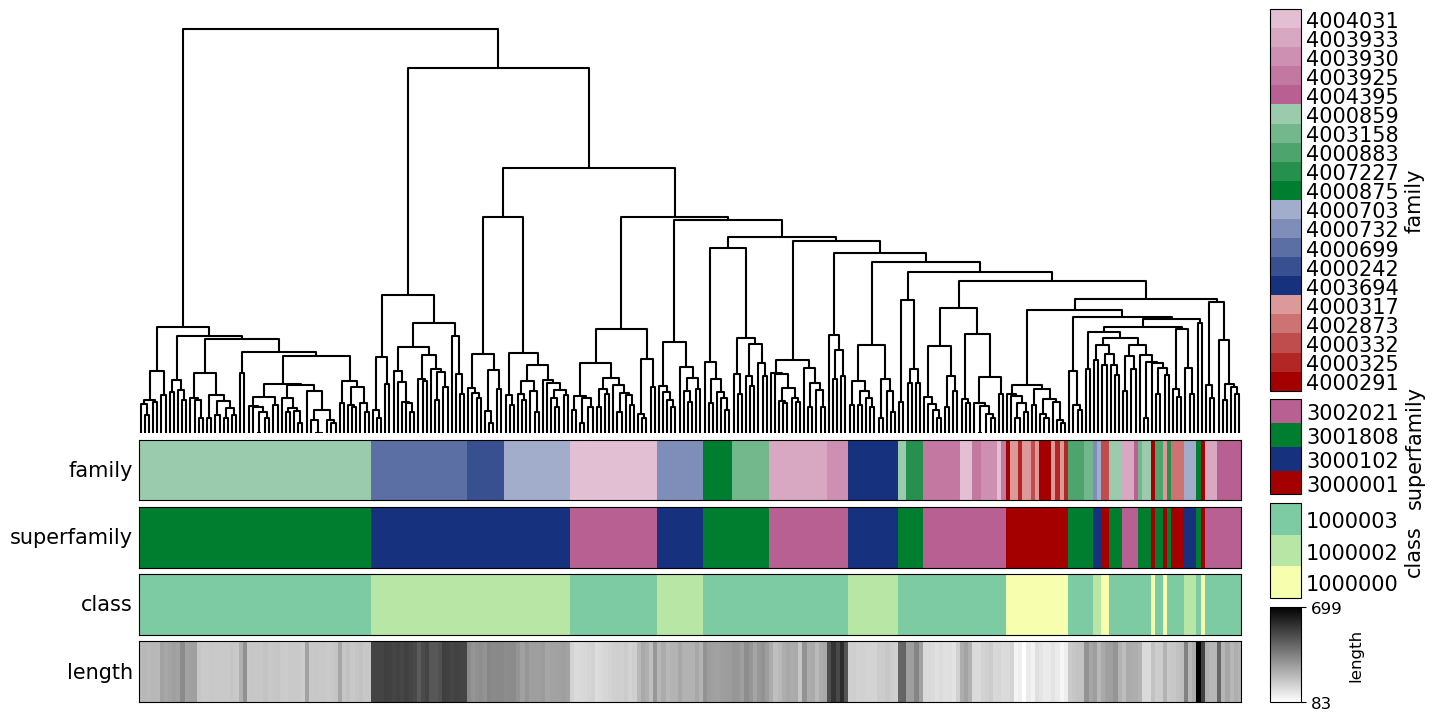

In [88]:
# fa_ind = 1
label_key = {'FA': 'family', 'SF': 'superfamily', 'CL': 'class'}

ncats = len(cat_to_plot) + 1 


fig = plt.figure(figsize=(15, 5+ncats))
# fig.suptitle(f'{M} neighbours', fontsize=16)


gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[4] + [1 for _ in range(ncats-1)],
                                                  hspace=0.05)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    label = label_key.get(cat_to_plot[n], cat_to_plot[n])
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center', size=15)
    ax.set_xticks([])
    # plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=label)
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label(label, size=15)  # Set label text and size
    cbar.set_ticks(ticks=yticks) # quirk with matplotlib
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels(key, size=15)
    legend_ax.tick_params(length=0)




# # legend_ax = fig.add_subplot(gs2[-2])

# ax = fig.add_subplot(gs1[-2], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_lr_balance[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('L/R balance', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# # cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# # cbar.set_label('L/R balance', size=12)  # Set label text and size
# # legend_ax.tick_params(axis='y', labelsize=12)


legend_ax = fig.add_subplot(gs2[-1])

ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
colrow = ax.imshow(ind_to_reslength[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_black, interpolation='nearest')
ax.set_yticks([])
ax.set_ylabel('length', rotation=0, ha='right', va='center', size=15)
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)

cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])
ys = [min(ind_to_reslength), max(ind_to_reslength)]
cbar.set_label('length', size=12)  # Set label text and size
legend_ax.tick_params(axis='y', labelsize=12)
legend_ax.set_yticks(ys)

# pos = legend_ax.get_position()

# # Adjust values: (x0, y0, width, height)
# new_pos = [pos.x0 + 0.12, pos.y0, pos.width, pos.height]
# legend_ax.set_position(new_pos)


if save_things:
    plt.savefig(fig_dir / 'scop_sample_clustering.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'scop_sample_clustering.png', dpi=300, bbox_inches='tight', transparent=True )
plt.show()

In [89]:
# scopcla_df_rf[scopcla_df_rf.p_id.isin(ind_to_id)]

In [90]:
# scopcla_df_rf[scopcla_df_rf.p_id.isin(ind_to_id)].groupby('p_id').SF.apply(list).apply(len).hist()

In [91]:
# sum(scopcla_df_rf[scopcla_df_rf.p_id.isin(ind_to_id)].groupby('p_id').SF.apply(list).apply(len)>1)

In [92]:
# scopcla_df_rf[scopcla_df_rf.p_id.isin(ind_to_id)].groupby('p_id').SF.apply(list).apply(len).hist()

<Axes: >

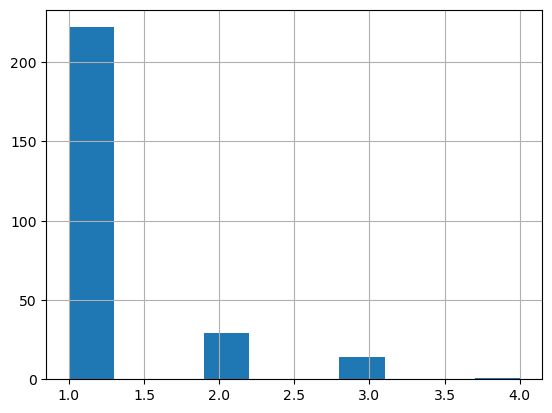

In [93]:
scopcla_df_rf[scopcla_df_rf.p_id.isin(ind_to_id)].groupby('p_id').FA.apply(list).apply(len).hist()

In [94]:
silhouette_score(squareform(cond_dist), labels=rel_meta_df.FA.values, metric="precomputed", )

0.13499181172275038

In [95]:
silhouette_score(squareform(cond_dist), labels=rel_meta_df.SF.values, metric="precomputed", )

0.02625344801014372

In [96]:
fa_dict = rel_meta_df.reset_index().groupby('FA').p_id.apply(list).to_dict()
sf_dict = rel_meta_df.reset_index().groupby('SF').p_id.apply(list).to_dict()

In [97]:
meta_subset = scopcla_df_rf[scopcla_df_rf.p_id.isin(ind_to_id)]
fa_dict = meta_subset.reset_index().groupby('FA').p_id.apply(list).to_dict()
sf_dict = meta_subset.reset_index().groupby('SF').p_id.apply(list).to_dict()

In [98]:
sum(meta_subset.reset_index().groupby('p_id').SF.apply(list).apply(len)>1)

44

In [99]:
sum(meta_subset.reset_index().groupby('p_id').FA.apply(list).apply(len)>1)

44

In [100]:

fa_stat_df = get_clustering_stats(Z=Z, ctype_to_id=fa_dict, ind_to_id=ind_to_id)

# fa_stat_df

In [101]:
purity = fa_stat_df.m_p.sum()/fa_stat_df.len.sum()
mean_pms = fa_stat_df.pms.mean()
print('Pure cluster coverage', purity)
print('Mean tightness', mean_pms)

Pure cluster coverage 0.9161290322580645
Mean tightness 0.44533619877161157


In [102]:
sf_stat_df = get_clustering_stats(Z=Z, ctype_to_id=sf_dict, ind_to_id=ind_to_id)

sf_stat_df

,labels,len,lps,pms,n_p,m_p,s_p
0,3000001,35,0.428571,0.729167,3,32,3
1,3000102,76,0.328947,0.361905,6,76,0
2,3000119,4,0.750000,0.266667,1,3,1
3,3000153,8,0.625000,0.049383,2,8,0
4,3000157,4,1.000000,1.000000,1,4,0
5,3001015,5,1.000000,1.000000,1,5,0
6,3001541,5,1.000000,1.000000,1,5,0
7,3001808,94,0.595745,0.353383,8,91,3
8,3001835,3,1.000000,1.000000,1,3,0
9,3002021,74,0.283784,0.456790,6,74,0


In [103]:
purity = sf_stat_df.m_p.sum()/sf_stat_df.len.sum()
mean_pms = sf_stat_df.pms.mean()
print('Pure cluster coverage', purity)
print('Mean tightness', mean_pms)

Pure cluster coverage 0.9744408945686901
Mean tightness 0.5706850324769369
